In [1]:
# Copyright 2020 (c) Cognizant Digital Business, Evolutionary AI. All rights reserved. Issued under the Apache 2.0 License.

In [2]:
#
# Notebook for evaluating prescriptions using lstm predictor.
#
# The main metric computed is based on how many other prescriptions
# each submission dominates on the pareto front of stringency vs cases.
#

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [4]:
# Set environment variable to find custom module
import os
current_pythonpath = os.getenv('PYTHONPATH', '')
repo_path = os.path.abspath('')
print(f"Adding repo path to PYTHONPATH...")
if current_pythonpath:
    new_pythonpath = f"{current_pythonpath}:{repo_path}"
else:
    new_pythonpath = repo_path
os.environ['PYTHONPATH'] = new_pythonpath

Adding repo path to PYTHONPATH...


In [5]:
# Can set these longer for better evaluation. Will increase eval time
START_DATE = '2020-08-01'
END_DATE = '2020-08-05'

In [6]:
NPI_COLS = ['C1M_School closing',
            'C2M_Workplace closing',
            'C3M_Cancel public events',
            'C4M_Restrictions on gatherings',
            'C5M_Close public transport',
            'C6M_Stay at home requirements',
            'C7M_Restrictions on internal movement',
            'C8EV_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6M_Facial Coverings']

In [7]:
prescription_files = {
    'NeatExample': 'examples/prescriptors/neat/tmp_prescriptions/test_prescriptions.csv'}
# ,
#     'Random1': 'examples/prescriptors/random/test/random_presc_1.csv',
#     'Random2': 'examples/prescriptors/random/test/random_presc_2.csv',
#     'Random3': 'examples/prescriptors/random/test/random_presc_3.csv',
# }

In [8]:
def generate_cases_and_stringency_for_prescriptions(prescription_file):
    
    # Load prescriptions
    pres_df = pd.read_csv(prescription_file)
    
    # Generate predictions for all prescriptions
    pred_dfs = []
    for idx in pres_df['PrescriptionIndex'].unique():
        idx_df = pres_df[pres_df['PrescriptionIndex'] == idx]
        idx_df = idx_df.drop(columns='PrescriptionIndex') # Predictor doesn't need this
        ip_file_path = 'prescription_{}.csv'.format(idx)
        idx_df.to_csv(ip_file_path)
        preds_file_path = 'test/predictions_{}.csv'.format(idx)
        
        # Run predictor
        !python examples/predictors/lstm/predict.py -s $START_DATE -e $END_DATE -ip $ip_file_path -o $preds_file_path
        
        # Collect predictions
        pred_df = pd.read_csv(preds_file_path,                                                               
                              parse_dates=['Date'],
                              encoding="ISO-8859-1",
                              error_bad_lines=True)
        pred_df['PrescriptionIndex'] = idx
        pred_dfs.append(pred_df)
    pred_df = pd.concat(pred_dfs)
    
    # Aggregate cases by prescription index and geo
    agg_pred_df = pred_df.groupby(['CountryName', 
                                   'RegionName', 
                                   'PrescriptionIndex'], dropna=False).mean().reset_index()

    # Aggregate stringency across npis
    pres_df['Stringency'] = pres_df[NPI_COLS].sum(axis=1)
    
    # Aggregate stringency by prescription index and geo
    agg_pres_df = pres_df.groupby(['CountryName', 
                                   'RegionName', 
                                   'PrescriptionIndex'], dropna=False).mean().reset_index()
    
    # Combine stringency and cases into a single df
    df = agg_pres_df.merge(agg_pred_df, how='outer', on=['CountryName', 
                                                         'RegionName', 
                                                         'PrescriptionIndex'])

    # Only keep columns of interest
    df = df[['CountryName', 
             'RegionName', 
             'PrescriptionIndex', 
             'PredictedDailyNewCases', 
             'Stringency']]
    
    return df

In [ ]:
# Collect case and stringency data for all prescriptors
dfs = []
for prescriptor_name, prescription_file in sorted(prescription_files.items()):
    print("Generating predictions for", prescriptor_name)
    df = generate_cases_and_stringency_for_prescriptions(prescription_file)
    df['PrescriptorName'] = prescriptor_name
    dfs.append(df)
df = pd.concat(dfs)

In [ ]:
df[df['CountryName'] == 'Afghanistan']

In [11]:
# Compute domination relationship for each pair of prescriptors for each geo
def compute_domination_df(df):
    country_names = []
    region_names = []
    dominating_names = []
    dominated_names = []
    dominated_idxs = []
    prescriptor_names = sorted(df['PrescriptorName'].unique())
    prescription_idxs = sorted(df['PrescriptionIndex'].unique())
    for country_name in df['CountryName'].unique():
        cdf = df[df['CountryName'] == country_name]
        for region_name in cdf['RegionName'].unique():
            print('Computing domination for', country_name, region_name)
            if pd.isna(region_name):
                rdf = cdf[cdf['RegionName'].isna()]
            else:
                rdf = cdf[cdf['RegionName'] == region_name]
            for name1 in prescriptor_names:
                dominated_prescriptions = set() # To collect all dominated prescriptions
                                                # this is a set, so each dominated
                                                # prescription is only counted once per
                                                # submission.
                name1_df = rdf[rdf['PrescriptorName'] == name1]
                name1_idxs = sorted(name1_df['PrescriptionIndex'].unique())
                for i in name1_idxs:
                    idf = name1_df[name1_df['PrescriptionIndex'] == i]
                    i_cases = idf['PredictedDailyNewCases'].values[0]
                    i_stringency = idf['Stringency'].values[0]
                    
                    # Compare name1 to all other prescriptions
                    for name2 in prescriptor_names:
                        if name1 != name2:
                            name2_df = rdf[rdf['PrescriptorName'] == name1]
                            name2_idxs = sorted(name2_df['PrescriptionIndex'].unique())  
                            for j in name2_idxs:
                                jdf = name2_df[name2_df['PrescriptionIndex'] == j]
                                j_cases = jdf['PredictedDailyNewCases'].values[0]
                                j_stringency = jdf['Stringency'].values[0]
                                if (i_cases < j_cases) and (i_stringency < j_stringency):
                                    dominated_prescriptions.add((name2, j))
                for name2, j in dominated_prescriptions:
                    country_names.append(country_name)
                    region_names.append(region_name)
                    dominating_names.append(name1)
                    dominated_names.append(name2)
                    dominated_idxs.append(j)
    ddf = pd.DataFrame({
        'CountryName': country_names,
        'RegionName': region_names,
        'DominatingName': dominating_names,
        'DominatedName': dominated_names,
        'DominatedIndex': dominated_idxs})
    return ddf

In [ ]:
ddf = compute_domination_df(df)

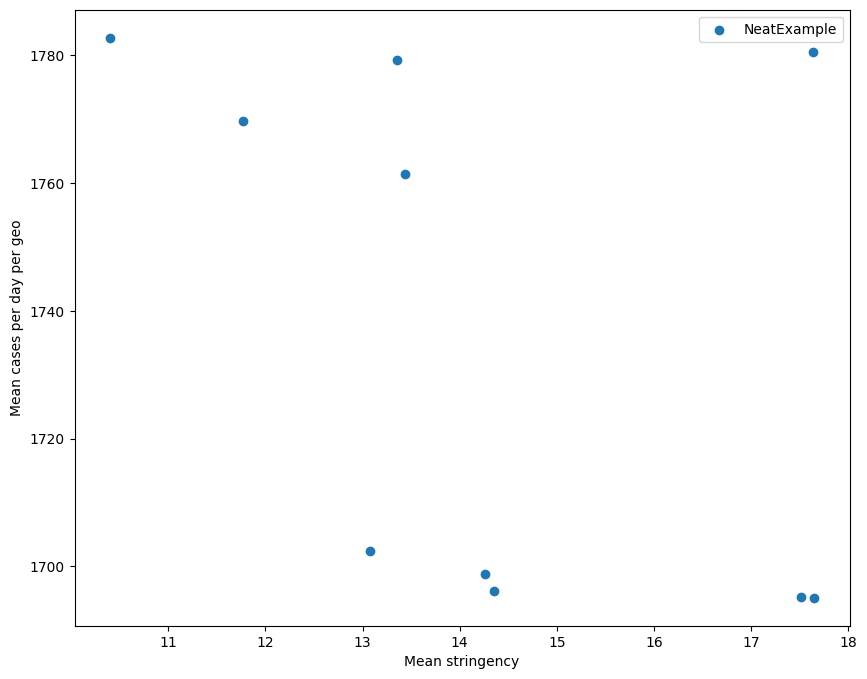

In [14]:
# Plot overall stringency and cases of each prescription
plt.figure(figsize=(10,8))
for prescriptor_name in prescription_files:
    pdf = df[df['PrescriptorName'] == prescriptor_name]
    overall_pdf = pdf.groupby('PrescriptionIndex').mean().reset_index()
    plt.scatter(overall_pdf['Stringency'],
                overall_pdf['PredictedDailyNewCases'], 
                label=prescriptor_name)
plt.xlabel('Mean stringency')
plt.ylabel('Mean cases per day per geo')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date', ylabel='Stringency'>

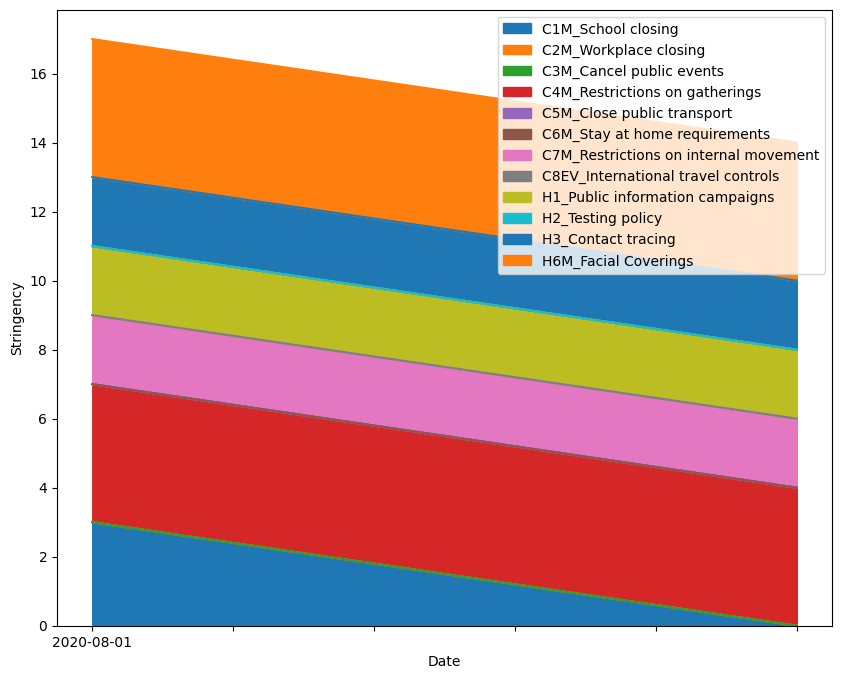

In [15]:
# Plot stacked line chart of npis over time for a prescription for a particular geo

submission_file = 'examples/prescriptors/neat/tmp_prescriptions/test_prescriptions.csv'
# submission_file = 'examples/prescriptors/random/test/random_presc_1.csv'

prescription_index = 2
country_name = 'United States'
region_name = None

pdf = pd.read_csv(submission_file)
gdf = pdf[(pdf['PrescriptionIndex'] == prescription_index) &
          (pdf['CountryName'] == country_name) &
          (pdf['RegionName'].isna() if region_name is None else (pdf['RegionName'] == 'region_name'))]
gdf.plot.area(x='Date', y=NPI_COLS, figsize=(10,8), ylabel='Stringency')